In [ ]:
# Gene Expression Clustering and Classification

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [4]:
# Load the training and testing datasets
df_train = pd.read_csv('data_set_ALL_AML_train.csv')
df_test = pd.read_csv('data_set_ALL_AML_independent.csv')

# Remove 'call' columns
df_train = df_train[[col for col in df_train.columns if 'call' not in col]]
df_test = df_test[[col for col in df_test.columns if 'call' not in col]]

In [5]:

# Reorder columns for easier processing
train_columns = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(1, 39)]
test_columns = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(39, 73)]
df_train = df_train.reindex(columns=train_columns)
df_test = df_test.reindex(columns=test_columns)

In [6]:
# Transpose datasets
X_train = df_train.T.reset_index(drop=True)
X_test = df_test.T.reset_index(drop=True)

In [7]:
# Extract labels and encode
labels = ['ALL', 'AML']
y = pd.read_csv('actual.csv')  # assuming labels are stored separately
y = y.replace({'ALL': 0, 'AML': 1})
y_train = y[y.patient <= 38].reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [ ]:
# Clean and convert to numeric
X_train.columns = X_train.iloc[1]
X_test.columns = X_test.iloc[1]

X_train = X_train.iloc[2:].apply(pd.to_numeric)
X_test = X_test.iloc[2:].apply(pd.to_numeric)


In [10]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# PCA for dimensionality reduction
pca = PCA()
pca.fit(X_train_scaled)
total_variance = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance / total_variance < 0.90:
    current_variance += pca.explained_variance_[k]
    k += 1

pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
# Classification using Logistic Regression with GridSearchCV
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10], 'penalty': ['l1', 'l2']}
log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=3, scoring='accuracy')
log_reg.fit(X_train, y_train.iloc[:, 1])
log_pred = log_reg.best_estimator_.predict(X_test)
print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:, 1], log_pred), 3))

Logistic Regression accuracy: 1.0


In [13]:
# Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

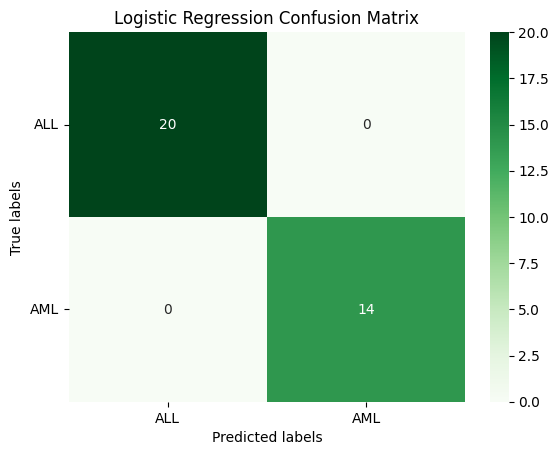

In [14]:
plot_confusion_matrix(y_test.iloc[:, 1], log_pred, 'Logistic Regression Confusion Matrix')

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluation metrics
accuracy = accuracy_score(y_test.iloc[:, 1], log_pred)
precision = precision_score(y_test.iloc[:, 1], log_pred)
recall = recall_score(y_test.iloc[:, 1], log_pred)
f1 = f1_score(y_test.iloc[:, 1], log_pred)
roc_auc = roc_auc_score(y_test.iloc[:, 1], log_pred)

# Display results
print("Logistic Regression Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.3f}")
print(f"Precision    : {precision:.3f}")
print(f"Recall       : {recall:.3f}")
print(f"F1 Score     : {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")

Logistic Regression Evaluation Metrics:
Accuracy     : 1.000
Precision    : 1.000
Recall       : 1.000
F1 Score     : 1.000
ROC AUC Score: 1.000
